In [1]:
import numpy as np
import pandas
import h5py
import matplotlib.pyplot as plt
from corner import corner

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import numpyro

import bilby
import gwpopulation
gwpopulation.set_backend('jax')

In [3]:
jax.devices()

[cuda(id=0)]

## Load the data

In [4]:
def load_posteriors():
    posteriors = []
    
    with h5py.File(
        './o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_samples.hdf5', 'r',
    ) as f:

        samples = f['original']
        num_obs, num_samples = samples['a_1'].shape
        
        for n in range(num_obs):
            posterior = pandas.DataFrame()
            for par in samples:
                posterior[par] = samples[par][n, :]

            posteriors.append(posterior)
    
    return posteriors

In [5]:
def load_injections():
    cut_far = 1.0
    cut_snr = 10.0
    
    injections = {}
    
    with h5py.File(
        './o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5', 'r',
    ) as f:
        samples = f['injections']
    
        ifars = [
            samples[par][:] for par in samples.keys()
            if ('ifar' in par) and ('cwb' not in par)
            ]
        ifar = np.max(ifars, axis=0)
        snr = samples['optimal_snr_net'][:]
        runs = samples['name'][:].astype(str)
        found = np.where(runs == 'o3', ifar > 1/cut_far, snr > cut_snr)
    
        mass_1 = samples['mass1_source'][:][found]
        mass_2 = samples['mass2_source'][:][found]
        spin1x = samples['spin1x'][:][found]
        spin1y = samples['spin1y'][:][found]
        spin1z = samples['spin1z'][:][found]
        spin2x = samples['spin2x'][:][found]
        spin2y = samples['spin2y'][:][found]
        spin2z = samples['spin2z'][:][found]
        redshift = samples['redshift'][:][found]
    
        mass_ratio = mass_2 / mass_1
        a_1 = (spin1x**2 + spin1y**2 + spin1z**2)**.5
        a_2 = (spin2x**2 + spin2y**2 + spin2z**2)**.5
        cos_tilt_1 = spin1z / a_1
        cos_tilt_2 = spin2z / a_2
    
        injections['mass_1'] = mass_1
        injections['mass_ratio'] = mass_ratio
        injections['a_1'] = a_1
        injections['a_2'] = a_2
        injections['cos_tilt_1'] = cos_tilt_1
        injections['cos_tilt_2'] = cos_tilt_2
        injections['redshift'] = redshift
    
        prior = samples['sampling_pdf'][:][found]
        prior *= mass_1 * 4 * np.pi**2 * a_1**2 * a_2**2
        injections['prior'] = prior
    
        dodgy = injections['redshift'] > 1.9
        for par in injections:
            injections[par] = injections[par][~dodgy]
    
        injections['total_generated'] = samples.attrs['total_generated']
    
    for par in injections:
        injections[par] = jnp.array(injections[par])
    
    return injections

## Define the population model

In [6]:
from gwpopulation.models.mass import SinglePeakSmoothedMassDistribution
from gwpopulation.models.spin import iid_spin
from gwpopulation.models.redshift import PowerLawRedshift
from gwpopulation.experimental.jax import NonCachingModel

In [7]:
def spin_model(dataset, xi_spin, sigma_spin, alpha_chi, beta_chi):
    amax = 1.0
    return iid_spin(dataset, xi_spin, sigma_spin, amax, alpha_chi, beta_chi)

In [8]:
def make_model():
    models = [
        SinglePeakSmoothedMassDistribution(),
        spin_model,
        PowerLawRedshift(cosmo_model = 'Planck15'),
    ]
    return NonCachingModel(models)

## Define the population likelihood

In [9]:
from gwpopulation.vt import ResamplingVT
from gwpopulation.hyperpe import HyperparameterLikelihood

In [10]:
selection_function = ResamplingVT(
    model = make_model(),
    data = load_injections(),
    n_events = len(load_posteriors()),
    marginalize_uncertainty = False,
    enforce_convergence = False,
)

In [11]:
likelihood = HyperparameterLikelihood(
    posteriors = load_posteriors(),
    hyper_prior = make_model(),
    selection_function = selection_function,
    maximum_uncertainty = jnp.inf,
)

## Define the prior

In [12]:
priors = bilby.prior.PriorDict()
priors['alpha'] = bilby.prior.Uniform(-4, 12)
priors['beta'] = bilby.prior.Uniform(-2, 7)
priors['mmin'] = bilby.prior.Uniform(6.5, 10)
priors['mmax'] = bilby.prior.Uniform(65, 100)
priors['lam'] = bilby.prior.Uniform(0, 1)
priors['mpp'] = bilby.prior.Uniform(20, 50)
priors['sigpp'] = bilby.prior.Uniform(1, 10)
priors['delta_m'] = bilby.prior.Uniform(0, 10)
priors['lamb'] = bilby.prior.Uniform(-6, 6)
priors['alpha_chi'] = bilby.prior.Uniform(1, 10)
priors['beta_chi'] = bilby.prior.Uniform(1, 10)
priors['xi_spin'] = bilby.prior.Uniform(0, 1)
priors['sigma_spin'] = bilby.prior.Uniform(0.1, 4)

## Variational inference with numpyro and gwpopulation

In [13]:
from gwpopulation.experimental.numpyro import construct_numpyro_model

In [14]:
model = construct_numpyro_model(likelihood, priors)

In [15]:
guide = numpyro.infer.autoguide.AutoNormal(model)
# guide = numpyro.infer.autoguide.AutoBNAFNormal(
#     model, num_flows = 1, hidden_factors = [8],
# )
optim = numpyro.optim.Adam(step_size = 1e-3)
loss = numpyro.infer.Trace_ELBO(num_particles = 1, vectorize_particles = True)
svi = numpyro.infer.SVI(model, guide, optim, loss)

In [16]:
result = svi.run(jax.random.PRNGKey(0), num_steps = 100, progress_bar = True)

100%|███████████████| 100/100 [00:23<00:00,  4.22it/s, init loss: 109.2982, avg. loss [96-100]: nan]


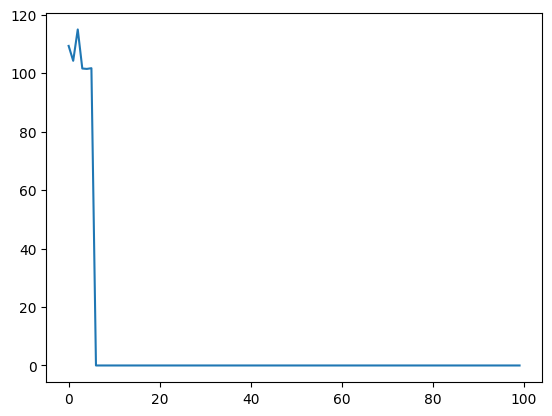

In [25]:
plt.plot(np.nan_to_num(result.losses));

In [18]:
predictive = numpyro.infer.Predictive(
    guide, params = result.params, num_samples = 1_000,
)
samples_scaled = predictive(jax.random.PRNGKey(1))

In [21]:
print(samples_scaled.keys())

dict_keys(['alpha_chi_scaled', 'alpha_scaled', 'beta_chi_scaled', 'beta_scaled', 'delta_m_scaled', 'lam_scaled', 'lamb_scaled', 'mmax_scaled', 'mmin_scaled', 'mpp_scaled', 'sigma_spin_scaled', 'sigpp_scaled', 'xi_spin_scaled'])


In [22]:
from gwpopulation.experimental.numpyro import bilby_to_numpyro_priors

In [19]:
def rescale(samples_scaled, priors):
    if isinstance(priors, bilby.prior.PriorDict):
        priors = bilby_to_numpyro_priors(priors)
    samples = {}
    base = numpyro.distributions.Normal(0, 1)
    for key, prior in priors.items():
        samples[key] = prior.icdf(base.cdf(samples_scaled[f'{key}_scaled']))
    return samples

In [20]:
samples = rescale(samples_scaled, priors)

In [23]:
print(samples.keys())

dict_keys(['alpha', 'beta', 'mmin', 'mmax', 'lam', 'mpp', 'sigpp', 'delta_m', 'lamb', 'alpha_chi', 'beta_chi', 'xi_spin', 'sigma_spin'])
